In [513]:
import numpy as np
import math
import struct
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

Make sure data is in float32

In [514]:
stuff=np.fromfile('/home/jwb/bits.txt',dtype='float32')

Take real and imaginary parts of complex signal

In [515]:
arr1=stuff[::2]
arr2=stuff[1::2]

In [525]:
arr1_trim = arr1[23000:33000]
arr2_trim = arr2[23000:33000]

Make a complex signal

In [526]:
signal=arr1+(1j * arr2 )
signal_trim = arr1_trim + 1j*arr2_trim

Real signal plot

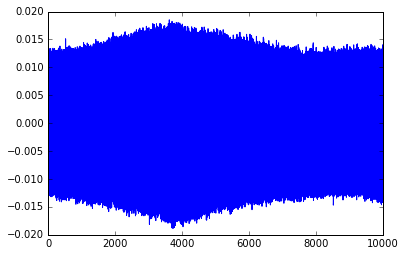

In [527]:
fig=plt.plot(arr1_trim)
#plt.plot(arr2)
#plt.xlim([60000,72000])

Complex signal plot

<function matplotlib.pyplot.axes>

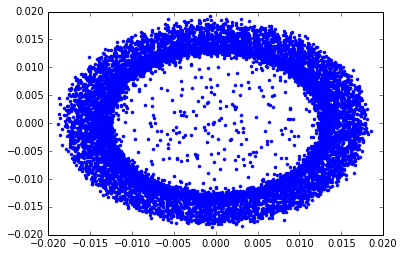

In [528]:
plt.plot(arr1_trim,arr2_trim, marker='.',linestyle='')
plt.axes

Calculate the frequency axis of the fft, then calculate the fft of the signal squared. Half of the frequency of the spike is an approximation of the frequency offset.

/home/jwb/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


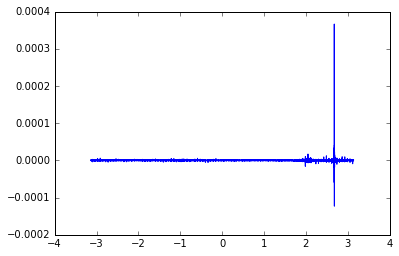

In [529]:
freq_data=np.fft.fftshift(np.fft.fft(signal_trim**4))
freq_axis=np.fft.fftfreq(len(signal_trim),(1/22050))
rad_axis= np.linspace(-np.pi, np.pi*(len(signal_trim)-1)/len(signal_trim), len(freq_data))
plt.plot(rad_axis,freq_data)

In [530]:
freq_offset=np.argmax(freq_data)/4
print("The frequency offset is {:06.2f} hertz".format(freq_axis[np.argmax(freq_data)]/4))
offset = rad_axis[np.argmax(freq_data)]/4
print("The frequency offset is {:06.5f} radians".format(offset))

The frequency offset is -405.17 hertz
The frequency offset is 0.67002 radians


In [531]:
correct=np.linspace(0,len(signal_trim)-1,len(signal_trim))
correct=-np.exp(-1j*correct*offset) 

<function matplotlib.pyplot.axes>

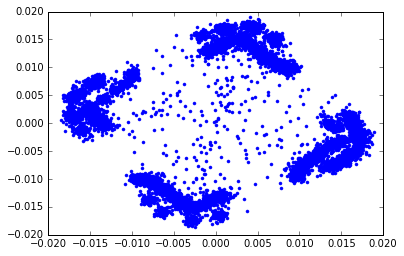

In [532]:
plt.plot(np.real(signal_trim*correct),np.imag(signal_trim*correct), marker='.',linestyle='')
plt.axes

(0, 1500)

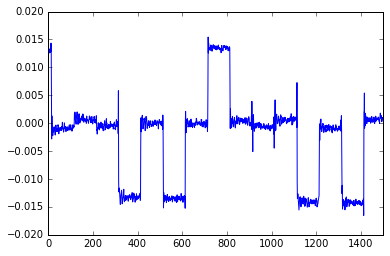

In [533]:
plt.plot(np.real(signal_trim*correct))
plt.xlim([0,1500])

(0, 1500)

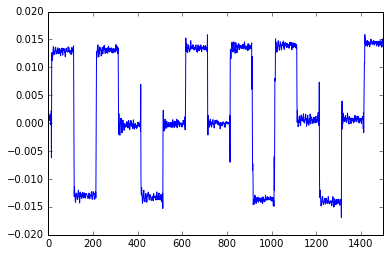

In [534]:
plt.plot(np.imag(signal_trim*correct))
plt.xlim([0,1500])